In [2]:
from pickle import POP
from tkinter import Grid
from matplotlib.lines import lineStyles
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [3]:
data = pd.read_csv('world_population.csv')
print(data.info(), data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rank                         234 non-null    int64  
 1   CCA3                         234 non-null    object 
 2   Country/Territory            234 non-null    object 
 3   Capital                      234 non-null    object 
 4   Continent                    234 non-null    object 
 5   2022 Population              234 non-null    int64  
 6   2020 Population              234 non-null    int64  
 7   2015 Population              234 non-null    int64  
 8   2010 Population              234 non-null    int64  
 9   2000 Population              234 non-null    int64  
 10  1990 Population              234 non-null    int64  
 11  1980 Population              234 non-null    int64  
 12  1970 Population              234 non-null    int64  
 13  Area (km²)          

In [5]:
years = ['2022 Population', '2020 Population', '2015 Population', '2010 Population',
         '2000 Population', '1990 Population', '1980 Population', '1970 Population']

melted = data.melt(
   id_vars=['Country/Territory', 'Continent', 'Capital', 'CCA3', 'Area (km²)', 'Density (per km²)', 'Growth Rate','World Population Percentage'],
    value_vars=years,
    var_name='Year',
    value_name='Population'
)

melted['Year'] = melted['Year'].str.extract(r'(\d{4})').astype(int)  
print(melted.info(), melted.describe(),melted.columns)
pop_by_year = melted.groupby('Year')['Population'].sum().reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country/Territory            1872 non-null   object 
 1   Continent                    1872 non-null   object 
 2   Capital                      1872 non-null   object 
 3   CCA3                         1872 non-null   object 
 4   Area (km²)                   1872 non-null   int64  
 5   Density (per km²)            1872 non-null   float64
 6   Growth Rate                  1872 non-null   float64
 7   World Population Percentage  1872 non-null   float64
 8   Year                         1872 non-null   int64  
 9   Population                   1872 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 146.4+ KB
None          Area (km²)  Density (per km²)  Growth Rate  \
count  1.872000e+03        1872.000000  1872.000000   
mean   5.814494e+0

grouping data by years nad making new table with years column

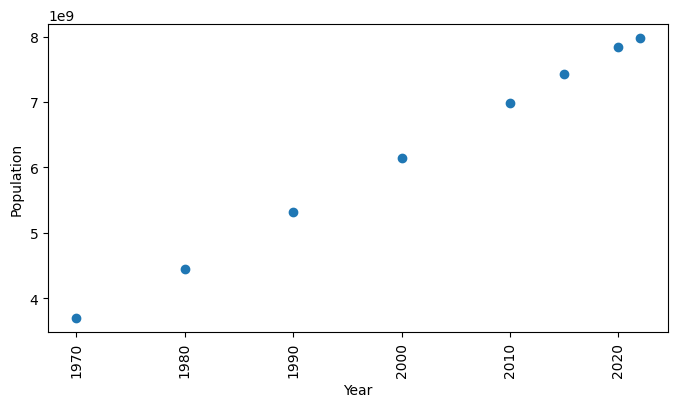

In [6]:
plt.figure(figsize=(8, 4))  
plt.scatter(pop_by_year['Year'], pop_by_year['Population'])
plt.xticks(rotation=90)
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()

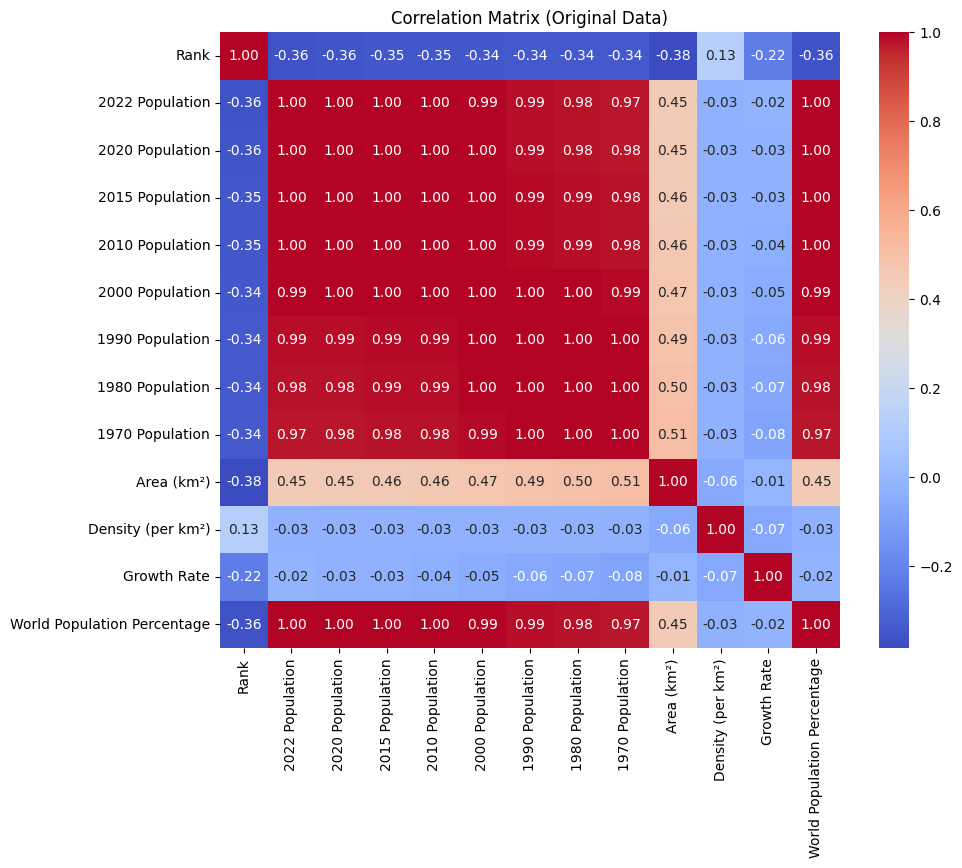

In [7]:
data_forcorr = data.select_dtypes(include=['number'])
melted_corr = melted.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(data_forcorr.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix (Original Data)')
plt.show()

correlation matrix for original data

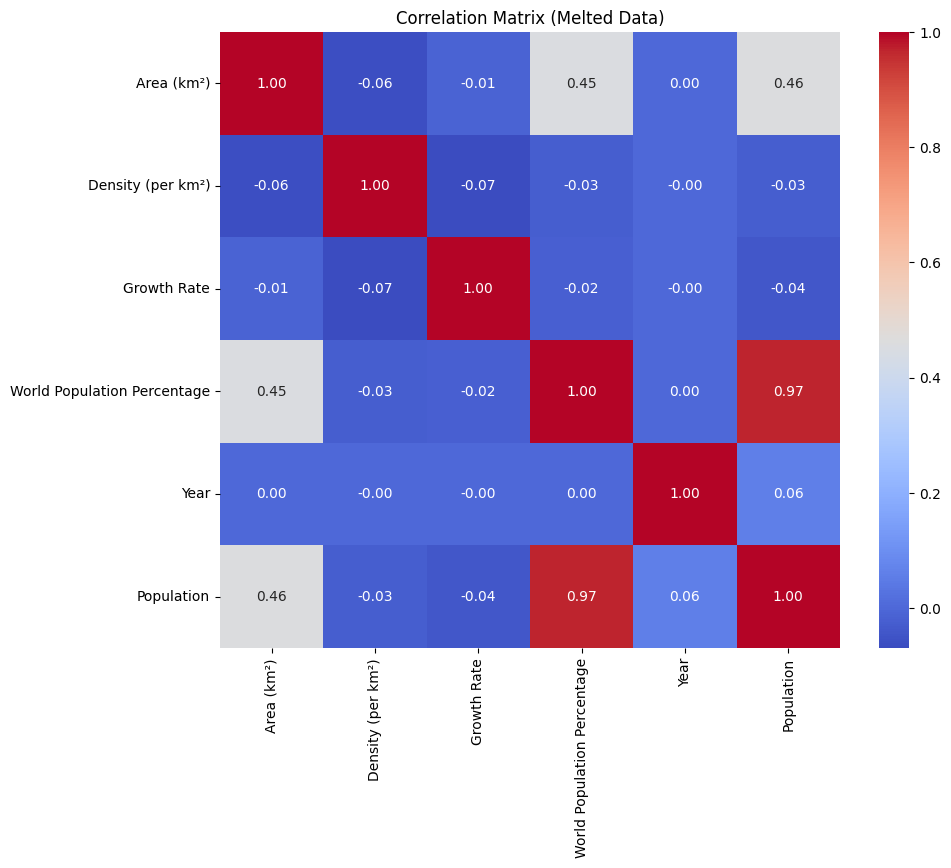

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(melted_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix (Melted Data)')
plt.show()

correlation matrix for pre-processed data

In [9]:
melted = pd.get_dummies(melted, columns=['Country/Territory', 'Continent', 'Capital', 'CCA3'])
X_for_pca = melted.drop(columns=['World Population Percentage','Year'], errors='ignore')
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(X_for_pca)
melted_pca = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
melted_pca['World Population Percentage'] = melted['World Population Percentage'].values
features = melted_pca.columns.tolist()[:-1]
x = melted_pca[features]
y = melted_pca['World Population Percentage']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    random_state=42,
    tree_method='hist',        
    gamma=0.1,                
    min_child_weight=2         
)

xgb_params = {
    'n_estimators': [200,400,300],
    'max_depth': [5,7],          
    'learning_rate': [ 0.03,0.05], 
    'subsample': [0.8,1.0],      
    'colsample_bytree': [ 0.8,1.0],
    'reg_alpha': [0,0.01,0.02],        
    'reg_lambda': [0.5,0]        
}

xgb_regression = GridSearchCV(
    model,
    xgb_params,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

xgb_regression.fit(X_train, y_train)
y_pred_new = xgb_regression.predict(X_test)

print(f"Best parameters for xgb: {xgb_regression.best_params_}")
print(f"MSE for xgb: {mean_squared_error(y_test, y_pred_new):.2f}")
print(f"MAE for xgb: {mean_absolute_error(y_test, y_pred_new):.2f}")
print(f"R^2 for xgb: {r2_score(y_test, y_pred_new):.2f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters for xgb: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
MSE for xgb: 0.05
MAE for xgb: 0.09
R^2 for xgb: 0.98


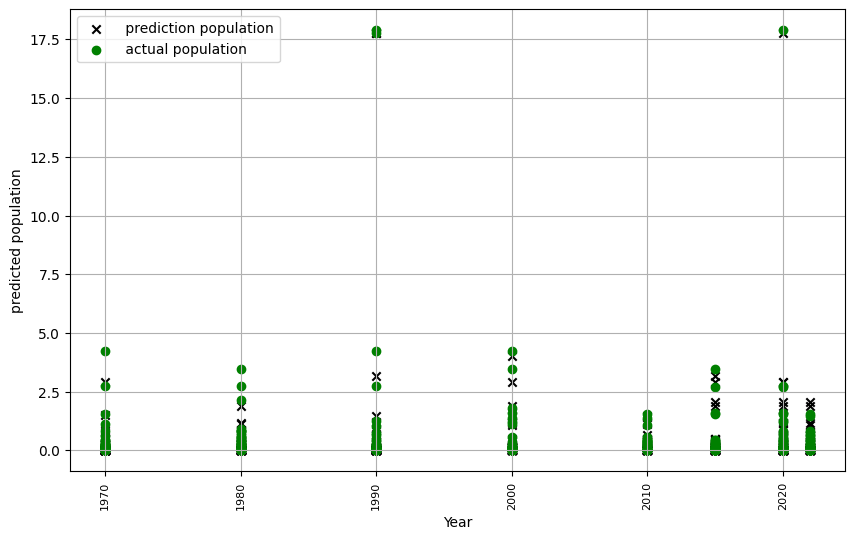

In [10]:
years_column = melted['Year'].copy()
melted_xgb=X_test.copy()
melted_xgb['Year'] = y_test.index.map(years_column)  
melted_xgb['y_pred']=y_pred_new
melted_xgb['y_test']=y_test
plt.figure(figsize=(10,6))
plt.scatter(melted_xgb['Year'],melted_xgb['y_pred'],label=' prediction population',marker='x',color='black')
plt.scatter(melted_xgb['Year'],melted_xgb['y_test'],label=' actual population',marker='o',color='green')
plt.xlabel('Year')
plt.ylabel('predicted population')
plt.xticks(rotation=90, fontsize=8)
plt.grid(True)
plt.legend()
plt.show()